## Library Import

In [67]:
import pandas as pd
import numpy as np
import torch

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

from pmdarima.arima.utils import ndiffs

from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
from statsmodels.tsa.stattools import adfuller
# Check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
print(f'Using device: {device}')

Using device: mps


## Import Data

In [126]:
# Import the data
df = pd.read_parquet("/Users/yiukitcheung/Documents/Projects/Stocks/train_data_repository/train_data.parquet")
df = df.dropna()

# Import test data
df_test = pd.read_parquet("/Users/yiukitcheung/Documents/Projects/Stocks/train_data_repository/test_data.parquet")
df_test = df_test.dropna()

In [98]:
df

,high,close_t-1,low,MACD_HIST,open,close_t-2,BodyDiff,volume,MACD,169EMA,...,Incremental_High_1.0,dual_channel_Alert_0,dual_channel_Alert_1,CandleStickType_red,Engulf_Alert_0,Engulf_Alert_1,MACD_Alert_0,MACD_Alert_1,timestamp,log_daily_return
1,21.922363,21.209585,21.159673,-0.195934,21.329381,21.076815,0.574015,268726000,0.241703,17.658991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.218851
2,22.496379,21.903397,21.852484,-0.133754,22.102055,21.209585,0.341415,248555000,0.270444,17.715279,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,2.435798
3,22.111038,22.443470,21.823532,-0.117002,22.032173,21.903397,0.010981,217655000,0.257946,17.766195,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3,-1.799764
4,21.761641,22.043154,21.288454,-0.130608,21.672793,22.443470,0.049914,245215000,0.211688,17.811568,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,4,-1.925010
5,21.382292,21.622879,20.615607,-0.196633,21.177643,22.043154,0.514119,343069000,0.096504,17.845121,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,5,-4.538192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,84.067903,82.409180,79.169722,-1.257190,83.935921,79.504669,4.272279,512208000,-1.361822,64.130016,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,651,-3.388353
652,83.309027,79.663643,78.209884,-0.975734,78.854772,82.409180,3.763376,424641000,-1.324299,64.347523,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,652,3.641607
653,88.316192,82.618149,83.373021,-0.419388,83.803948,79.663643,3.916343,551011000,-0.872800,64.622497,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,653,5.992387
654,87.977240,87.720291,85.251699,-0.043159,87.580311,82.618149,0.161975,388971000,-0.507361,64.894494,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,654,0.025071


## ARIMA - AutoRegressive Integratred Moving Average Model

#### ARIMA Equation:
$$
\phi(L)(1 - L)^d y_t = \theta(L)\epsilon_t
$$

Where:
- $y_t$: The value of the time series at time $t$.
- $L$: The **lag operator**, where $L y_t = y_{t-1}$ (shifts the series by one period).
- $\phi(L)$: The **autoregressive (AR)** part of the model.
- $\theta(L)$: The **moving average (MA)** part of the model.
- $\epsilon_t$: The white noise error term at time $t$.

#### Expanded Equation:

$$
y_t = \alpha + \sum_{i=1}^{p} \phi_i y_{t-i} + \sum_{j=1}^{q} \theta_j \epsilon_{t-j} + \epsilon_t
$$

Where:
- $\alpha$: The intercept or constant term (optional).
- $\phi_i$: Coefficients of the autoregressive terms (AR).
- $\theta_j$: Coefficients of the moving average terms (MA).
- $\epsilon_t$: The white noise error term.

#### Assumption:
 1. Stationary
 2. Equal Variance 
 3. Independence 
#### Define 

* p - order of AR term
* d - the number of difference to make the time series stationary 
* q - order of MA term

### Differencing Term - D Term
Hypothesis Test for Stationality

In [69]:
# Extract the close price and daily return
close = df['close'].dropna()

close_result = adfuller(close)
return_result = adfuller(close.diff(1).dropna())

print(f'Close p-value: {close_result[1]} | Daily return p-value: {return_result[1]}')


Close p-value: 0.9983383053326383 | Daily return p-value: 9.122169101268048e-28


ADF Plot

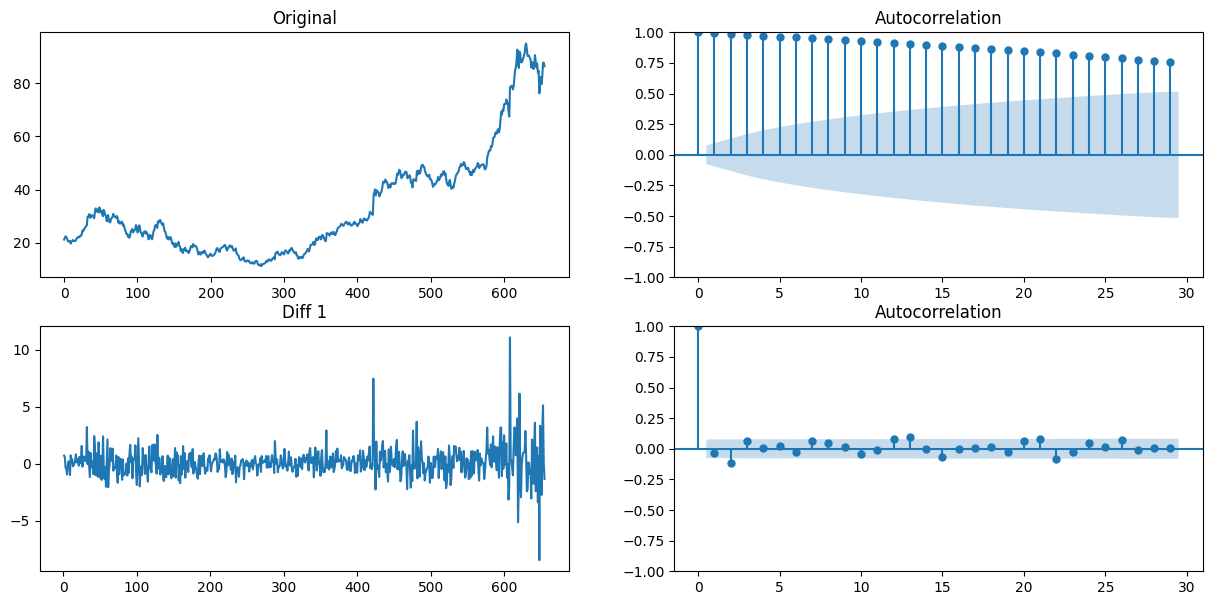

In [70]:
# Plot the original and daily return
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 7))

ax1.plot(close)
plot_acf(close, ax=ax2)
ax1.set_title("Original")

ax3.plot(close.diff(1).dropna())
ax3.set_title("Diff 1")
plot_acf(close.diff(1).dropna(), ax=ax4)

plt.show()


In [71]:
# Check the number of Arima differencing term
best_lags = ndiffs(close.dropna(), test='adf')
print(f'Arima differencing Term to maintain Stationality: {best_lags}')

Arima differencing Term to maintain Stationality: 1


### Order of Moving Average Term - Q Term

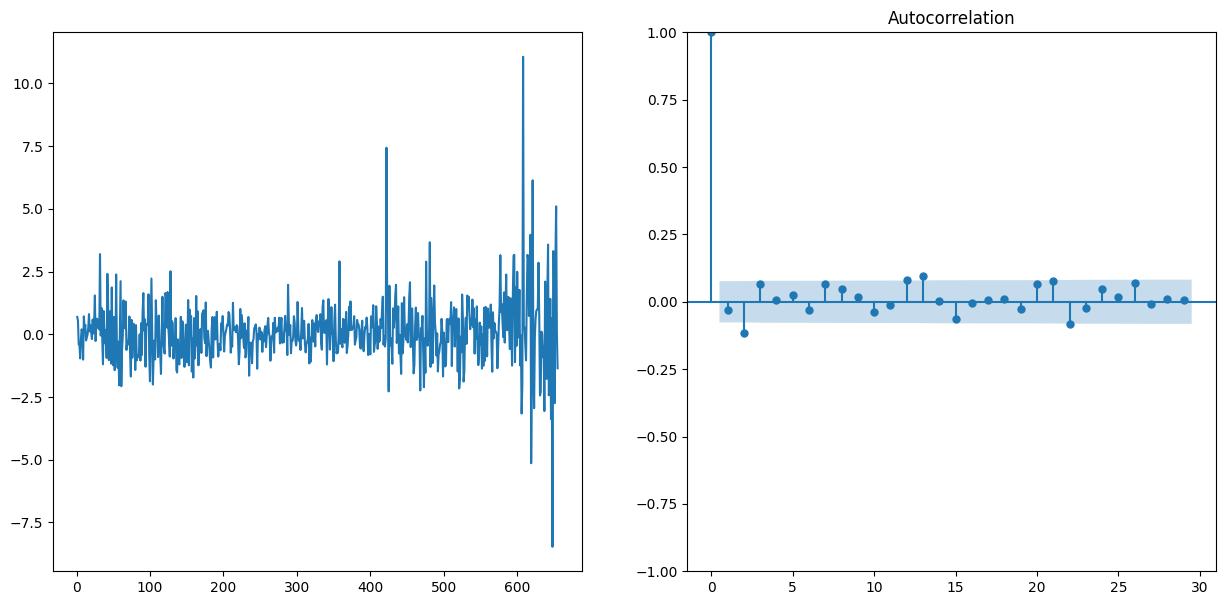

In [72]:
# Plot only the acf plot for daily return
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.plot(close.diff(1).dropna())
plot_acf(close.diff(1).dropna(), ax=ax2)
plt.show()

### Order of AutoRegressive Term - P Term

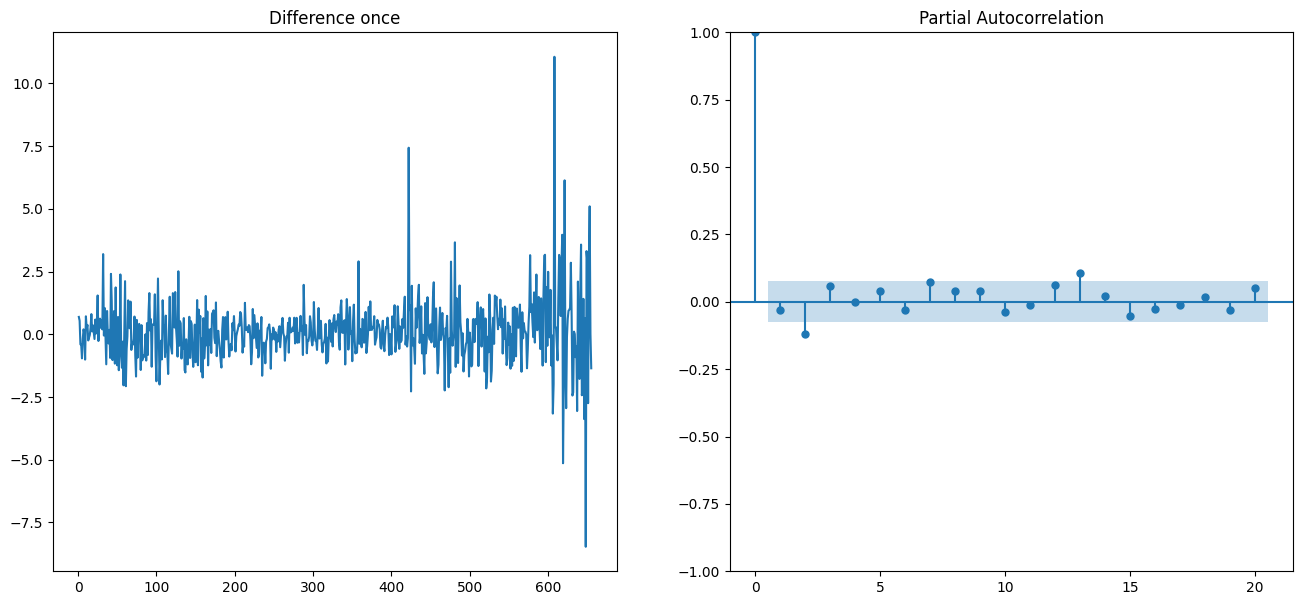

In [73]:
# Plot the pacf plot for daily return
fig, (axl, ax2) = plt.subplots(1, 2, figsize=(16, 7))
axl.plot(close.diff(1).dropna())
axl.set_title( "Difference once")
ax2.set_ylim(0, 1)
plot_pacf(close.diff(1).dropna(), lags=20, ax=ax2);

### Initialize ARIMA Model

* p = 1
* d = 1
* q = 1

In [74]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA model
arima = ARIMA(close, order=(1, 1, 1))

# Fit the model
ARIMA_model = arima.fit()

# Print the summary
print(ARIMA_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  656
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1072.928
Date:                Tue, 24 Sep 2024   AIC                           2151.856
Time:                        23:28:41   BIC                           2165.309
Sample:                             0   HQIC                          2157.072
                                - 656                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8108      0.078    -10.329      0.000      -0.965      -0.657
ma.L1          0.8656      0.069     12.485      0.000       0.730       1.001
sigma2         1.5499      0.029     53.405      0.0

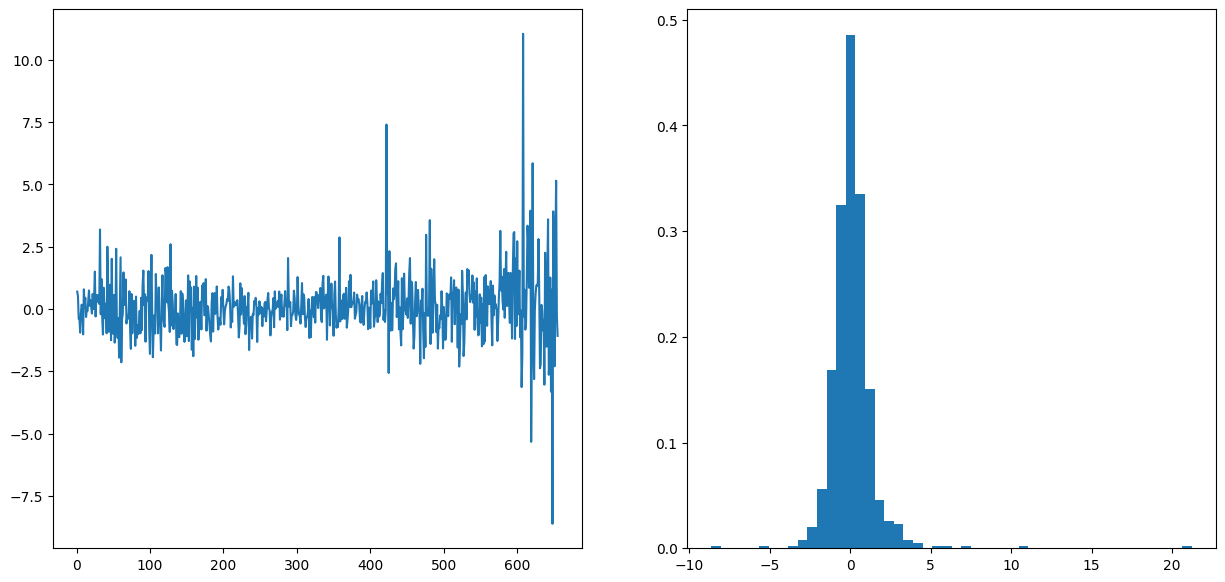

In [75]:
# Plot Residuals
residuals = ARIMA_model.resid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.plot(residuals.iloc[1:]) 
ax2.hist(residuals,density=True, bins=50)
plt.show()

### Baseline model - ARIMA 
* Forcast 1 step after known value
* Train test split prediction sabotage the nature of time series prediction

/Users/yiukitcheung/Documents/Projects/Stocks/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yiukitcheung/Documents/Projects/Stocks/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yiukitcheung/Documents/Projects/Stocks/.venv/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:615: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


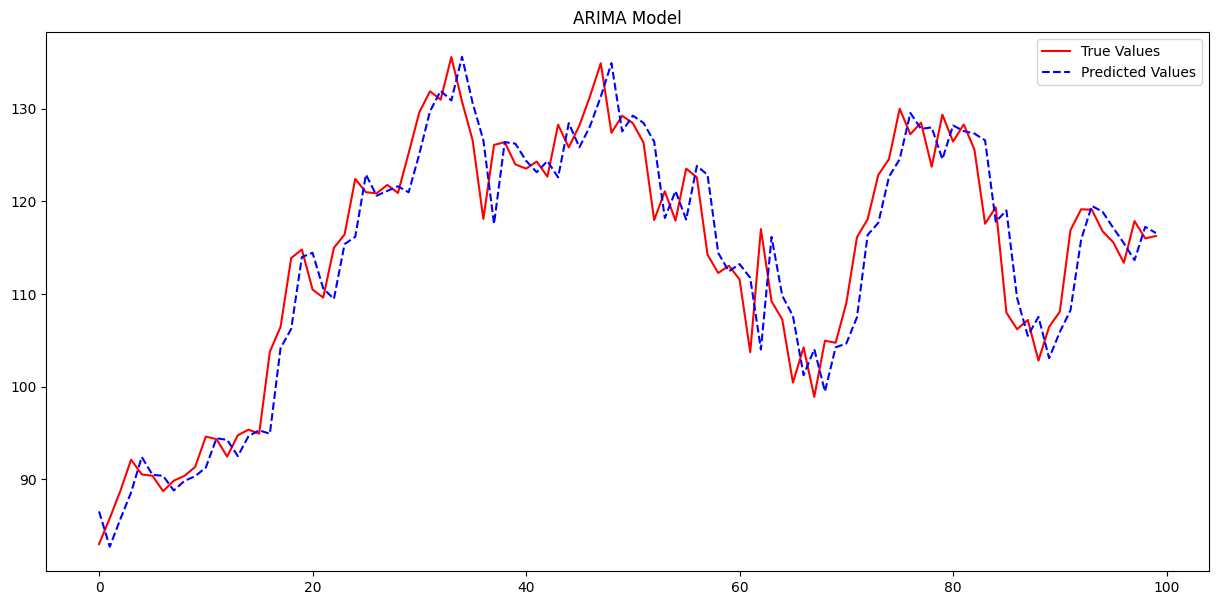

MASE: 4.119557885534923 | MSE: 18.923286861989908


In [76]:
def rolling_forecast(train_data, test_data, ARIMA_model):
    y_train = train_data['close']
    y_test = test_data['close']
    history = list(y_train)  # Start with the training data in a list
    
    predictions = []
    
    # Perform rolling forecast for each time step in the test data
    for t in range(len(y_test)):
        model = ARIMA(history, order=(1, 1, 1)) 
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1)  # Forecast the next step
        predictions.append(pred[0])  # Store the prediction
        history.append(y_test.iloc[t])  # Append the actual test value to history (recursive)

    return np.array(predictions)

# Performance Metrics
def time_series_baseline(train_data=df, test_data=df_test):
    y_train = df['close']
    y_test = df_test['close']
    pred = rolling_forecast(train_data, test_data, ARIMA_model)
    
    # Compare prediction with Naive forecast
    mase = MeanAbsoluteScaledError()
    mase_score = mase(y_test, pred, y_train=y_train)
    
    # Compute the MSE
    mse_score = np.mean((y_test - pred)**2)
    
    # plot the prediction vs true values
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.plot(y_test, color='red', label='True Values')
    ax.plot(pred, color='blue', linestyle='--', label='Predicted Values')
    ax.legend()
    plt.title("ARIMA Model")
    plt.show()
    
    return mase_score, mse_score
        
basic_time_series_model = time_series_baseline()

mase_score = basic_time_series_model[0]
mse_score = basic_time_series_model[1]

print(f'MASE: {mase_score} | MSE: {mse_score}')

## Base Model (Gaussian Process)

In [133]:
from sklearn.gaussian_process.kernels import  RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler

14.581319557719398

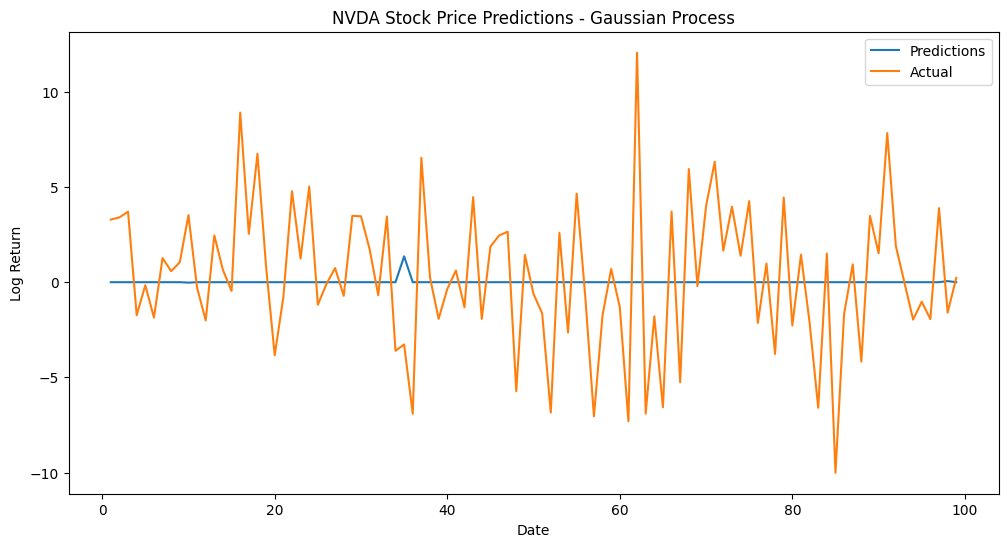

In [142]:
def gausian_baseline(train_df,test_df):
    # Scale the desired features
    desired_features = ['high', 'close_t-1', 'low', 'MACD_HIST', 'open', 'close_t-2',
                        'BodyDiff', 'volume', 'MACD', '169EMA', '144EMA', 'close',
                        'MACD_SIGNAL', '169EMA_Lower', '13EMA', '8EMA', '169EMA_Upper',
                        'close_t-3']
    scaler = StandardScaler()
    scaler.fit_transform(train_df[desired_features])
    scaler.fit_transform(test_df[desired_features])
    
    # Prepare the data
    X_train = train_df.copy()
    X_train = X_train.dropna()
    y_train = X_train['log_daily_return']
    X_train = X_train.drop(['timestamp',"log_daily_return"], axis=1)
    
    X_test = test_df.copy()
    X_test = X_test.dropna()
    y_test = X_test['log_daily_return']
    X_test = X_test.drop(['timestamp',"log_daily_return"], axis=1)

    # Train the model
    kernel = RBF()
    model = GaussianProcessRegressor(kernel=kernel, random_state=42, n_restarts_optimizer=50)
    model.fit(X_train, y_train)

    # Make predictions on the testing set
    pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, pred)
    
    # Plot predictions and actual stock prices
    plt.figure(figsize=(12, 6))
    plt.plot(X_test.index, (pred), label='Predictions')
    plt.plot(X_test.index, (y_test), label='Actual')
    plt.title('NVDA Stock Price Predictions - Gaussian Process')
    plt.xlabel('Date')
    plt.ylabel('Log Return')
    plt.legend()
    
    return mse

gausian_baseline(df, df_test)

In [141]:
df_test

,high,close_t-1,low,MACD_HIST,open,close_t-2,BodyDiff,volume,MACD,169EMA,...,Incremental_High_1.0,dual_channel_Alert_0,dual_channel_Alert_1,CandleStickType_red,Engulf_Alert_0,Engulf_Alert_1,MACD_Alert_0,MACD_Alert_1,timestamp,log_daily_return
1,86.222540,83.027077,83.186047,0.101017,84.434838,86.387512,1.367774,377898000,-0.311262,65.598232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.288267
2,89.266031,85.802612,87.025409,0.356199,87.774284,83.027077,0.999832,398341000,0.032971,65.870889,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2,3.404567
3,92.204538,88.774117,89.040068,0.714234,89.375011,85.802612,2.749539,376203000,0.569564,66.179756,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3,3.704634
4,91.765610,92.124550,88.996078,0.801323,91.082726,88.774117,0.543908,437342000,0.856983,66.466333,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4,-1.736277
5,91.178710,90.538818,89.405005,0.804334,89.467998,92.124550,0.928845,325721000,1.061078,66.747868,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5,-0.156935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,118.800003,116.779999,114.830002,0.307672,118.169998,119.099998,2.580002,231925900,-0.715071,99.417078,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,95,-1.024240
96,117.699997,115.589996,113.220001,0.176437,115.889999,116.779999,2.519997,310318900,-0.802197,99.581230,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,96,-1.939259
97,119.660004,113.370003,117.250000,0.381034,117.349998,115.589996,0.520004,293506400,-0.502342,99.796392,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,97,3.892552
98,118.620003,117.870003,115.389999,0.378011,117.059998,113.370003,1.059998,382008700,-0.410862,99.987022,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,98,-1.599215


## Transformer Architecture

In [90]:
import pandas as pd
import numpy as np
import torch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
from torch.utils.data import Dataset, DataLoader
import math
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm
import os

import matplotlib.pyplot as plt
import torch.nn as nn
import plotly.graph_objects as go

#### Data Loading

In [91]:
class TimeSeriesDataset(Dataset):
  def __init__(self, dataframe, window_size):

    self.window_size = window_size
    
    # Convert dataframe to tensors
    features = torch.tensor(dataframe.drop(['close'],axis=1).values, dtype=torch.float32)
    targets = torch.tensor(dataframe['close'].values, dtype=torch.float32)

    self.windows = []
    self.targets = []
    
    # Genearate windows
    max_num_windows = len(features) - self.window_size 
    
    for i in range(max_num_windows):
      
      # Extract window data and target
      window_data_tensor = features[i:i + self.window_size]
      target = targets[i + self.window_size] # Predict the next day's close price
      
      # Append to the list
      self.windows.append(window_data_tensor)
      self.targets.append(target)

  def __len__(self):
    return len(self.windows)

  def __getitem__(self, idx):
    if idx >= len(self.windows):
      raise IndexError("Index out of range")
    return self.windows[idx], self.targets[idx]

#### Model Architecture Class

In [110]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, dropout=0.1, max_len=256):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)

    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0).transpose(0, 1)
    self.register_buffer('pe', pe)

  def forward(self, x):
    x = x + self.pe[:x.size(0), :]
    return self.dropout(x)

class TransformerModel(nn.Module):
  def __init__(self, input_dim, d_model, nhead, num_encoder_layers,
                num_decoder_layers, dim_feedforward, dropout):

    super(TransformerModel, self).__init__()
    self.linear_encoder = nn.Linear(input_dim, d_model)
    self.pos_encoder = PositionalEncoding(d_model, dropout)
    self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dim_feedforward),
      nn.BatchNorm1d(dim_feedforward),
      nn.ReLU(),
      nn.Linear(dim_feedforward, d_model),
      nn.BatchNorm1d(d_model),
      nn.ReLU())
    self.linear_decoder = nn.Linear(d_model, 1)
    self.d_model = d_model

  def forward(self, x):
    # Validate h3_indices
        
    # Encode the input features
    x = self.linear_encoder(x) * math.sqrt(self.d_model)
    # Add positional encoding to input features
    x = self.pos_encoder(x)
    # Transformer expects inputs in the shape (S, N, E) -> (sequence_length, batch_size, d_model)
    x = x.transpose(0, 1)
    # Pass through the transformer
    transformer_output = self.transformer(x, x)

    # Apply feedforward network with BatchNorm1d
    batch_size, seq_len, feature_dim = transformer_output.size()
    transformer_output = transformer_output.contiguous().view(-1, feature_dim)
    # Apply feedforward network
    transformer_output = self.ffn(transformer_output)
    # Use the last time step for each sequence in the batch
    transformer_output = transformer_output.view(seq_len, batch_size, self.d_model).transpose(0, 1).contiguous()
    output = self.linear_decoder(transformer_output[-1])
    return output.squeeze(1)

def init_weights(m):
  if type(m) in [nn.Linear, nn.Conv2d]:
    nn.init.xavier_uniform_(m.weight)
    if m.bias is not None:
      nn.init.zeros_(m.bias)


#### Train Class

In [111]:
class TimeSeriesTrainer:
    def __init__(self, model, epochs, criterion, optimizer, verbose=True):
        """
        Args:
            model (torch.nn.Module): The PyTorch model to train.
            epochs (int): Number of epochs to train.
            criterion (torch.nn.Module): The loss function.
            optimizer (torch.optim.Optimizer): The optimizer.
            scheduler (optional): Learning rate scheduler (if any).
        """
        self.l1_lambda = 0.001
        self.l2_lambda = 0.001
        
        self.model = model
        self.epochs = epochs
        self.criterion = criterion
        self.optimizer = optimizer
        self.verbose = verbose
        self.model_path = '/Users/yiukitcheung/Documents/Projects/Stocks/model_repository'
        
    def train(self, train_dataloader, epoch, device):
        self.model.train()

        # Initialize accumulators
        total_loss = 0
        train_pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader),
                        desc=f"Epoch {epoch + 1}/{self.epochs}")

        # Train over batches
        for _, (x_batch, y_batch) in train_pbar:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            self.optimizer.zero_grad()

            # Predict
            y_pred = self.model(x_batch)

            # Compute loss
            # Calculate regularization terms
            l1_regularization = torch.tensor(0.).to(device)
            l2_regularization = torch.tensor(0.).to(device)
            for param in self.model.parameters():
                l1_regularization += torch.norm(param, 1)
                l2_regularization += torch.norm(param, 2)

            # Compute Loss
            loss = self.criterion(y_pred, y_batch) + self.l1_lambda * l1_regularization + self.l2_lambda * l2_regularization
            loss.backward()
            self.optimizer.step()

            # Accumulate loss
            total_loss += loss.item()

            # Update progress bar
            train_pbar.set_postfix({'Batch Loss': f"{loss.item():.4f}"})

        # Calculate average loss
        avg_train_loss = total_loss / len(train_dataloader)

        return avg_train_loss

    def validate(self, test_dataloader, device):
        self.model.eval()

        # Initialize accumulators
        total_loss = 0

        with torch.no_grad():
            for batch in tqdm(test_dataloader, desc="Validating"):
                x_batch, y_batch = batch
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                # Predict
                y_pred = self.model(x_batch)

                # Compute loss
                batch_loss = self.criterion(y_pred, y_batch)
                total_loss += batch_loss.item()

        # Compute average loss
        avg_val_loss = total_loss / len(test_dataloader)



        return avg_val_loss

    def run(self, df, window_size, batch_size, device):
        """
        Run the training and validation over multiple folds.
        Args:
            df (pd.DataFrame): Dataframe containing the data.
            window_size (int): The size of the sliding window.
            batch_size (int): Batch size for dataloaders.
            device (torch.device): The device to train on.
        """
        tscv = TimeSeriesSplit(n_splits=4)
        folds_val_results = {}
        folds_train_results = {}

        # Expanding Window Cross-Validation Folds
        for fold, (train_index, val_index) in enumerate(tscv.split(df)):
            train_df = df.iloc[train_index]
            val_df = df.iloc[val_index]

            # Create datasets and dataloaders
            train_dataset = TimeSeriesDataset(train_df, window_size=window_size)
            val_dataset = TimeSeriesDataset(val_df, window_size=window_size)

            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
            val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            
            # Initialize results containers for each fold
            fold_val_results = []
            fold_train_results = []

            # Train and validate for each epoch
            for epoch in range(self.epochs):
                avg_train_loss = self.train(train_dataloader, epoch, device)
                avg_val_loss = self.validate(val_dataloader, device)
                
                if self.verbose:
                    print(f"Fold {fold+1}: Epoch [{epoch + 1}/{self.epochs}], Train Loss: {avg_train_loss:.4f}")
                    print(f"Fold {fold+1}: Epoch [{epoch + 1}/{self.epochs}], Val Loss: {avg_val_loss:.4f}")

                # Record validation and training loss
                fold_val_results.append(avg_val_loss)
                fold_train_results.append(avg_train_loss)

            # Store results for each fold
            folds_val_results[fold] = fold_val_results
            folds_train_results[fold] = fold_train_results

        # Store the model
        self.save_model()
        
        return folds_train_results, folds_val_results
    
    def save_model(self):
        save_path = os.path.join(self.model_path+'_NVDA.pth')
        torch.save(self.model.state_dict(),save_path)
    
    def viz_performance(self, train, eval):
        # Assuming folds_train_results and folds_val_results are populated as in your example
        # Create a new figure
        fig = go.Figure()

        # Define a limited set of contrasting colors
        colors = ['blue', 'green', 'red', 'purple']

        # Number of folds
        folds = len(train)

        # Plot each fold
        for i in range(folds):
            color = colors[i // 4]  # Cycle through colors every 4 folds
            epochs = np.arange(i * len(train[i]), (i + 1) * len(train[i]))
            
            fig.add_trace(go.Scatter(x=epochs, y=train[i], mode='lines', name='Train' if i == 0 else None,
                                    line=dict(color=color, dash='solid'), showlegend=(i == 0)))
            fig.add_trace(go.Scatter(x=epochs, y=eval[i], mode='lines', name='Eval' if i == 0 else None,
                                    line=dict(color=color, dash='dash'), showlegend=(i == 0)))

            # Add vertical line to indicate fold boundary
            if i < folds - 1:
                fig.add_shape(type="line", x0=(i + 1) * len(train[i]) - 0.5,
                                y0=min(min(train[i]), min(eval[i])),
                                x1=(i + 1) * len(train[i]) - 0.5,
                                y1=max(max(train[i]), max(eval[i])),
                                line=dict(color="black", dash="dash"))

            # Add text annotation to indicate fold number
            fig.add_annotation(x=(i + 0.5) * len(train[i]),
                                y=max(max(train[i]), max(eval[i])),
                                text=f"Fold {i + 1}", showarrow=False, yshift=10)

        # Add titles and labels
        fig.update_layout(
            title='Training and Evaluation Metrics',
            xaxis_title='Epochs',
            yaxis_title='Metric',
            legend_title='Legend',
            template='plotly_white'
        )

        # Show the plot
        fig.show()

## Machine Learning Pipeline

In [113]:

# Define model, criterion, optimizer, and device

# Set device to apple silicon if available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device found.")
else:
    print ("MPS device not found.")

# Initialize the model
model = TransformerModel(input_dim= df.shape[1]-1, d_model=128, nhead=8, num_encoder_layers=4,
                        num_decoder_layers=4, dim_feedforward=512, dropout=0.1)

# Apply weight initialization                          
model.apply(init_weights)

# Set model to device
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Create the trainer object
trainer = TimeSeriesTrainer(model=model, 
                            epochs=50,
                            criterion=criterion,
                            optimizer=optimizer,
                            verbose=False)

# Run training with cross-validation
folds_train_results, folds_val_results = trainer.run(df=df, 
                                                    window_size=30, 
                                                    batch_size=32, 
                                                    device=device)

/Users/yiukitcheung/Documents/Projects/Stocks/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


MPS device found.


Validating: 100%|██████████| 4/4 [00:00<00:00, 97.10it/s]


In [112]:

# class test_model:

#     def __init__(self,df,model,device):
#         self.df = df
#         self.model = model
#         self.device = device
#         self.window_size = 30

#     def predict(self):
#         test_dataset = TimeSeriesDataset(self.df, window_size=self.window_size)
#         test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)
#         self.model.eval()        
        
#         all_pred = []
#         all_targets = []
#         with torch.no_grad():
#             for batch in tqdm(test_dataloader, desc="Predicting..."):
#                 inputs, targets = batch
#                 inputs, targets = inputs.to(self.device), targets.to(self.device)

#                 # Predict
#                 y_pred = self.model(inputs)
                
#                 # Convert to numpy arrays
#                 y_pred = y_pred.cpu().numpy()
#                 targets = targets.cpu().numpy()
                
#                 # Append to the list
#                 all_pred.append(y_pred)
#                 all_targets.append(targets) 
            
#             # Concatenate all the predictions and targets
#             all_pred = np.concatenate(all_pred, axis=0)
#             all_targets = np.concatenate(all_targets, axis=0)
            
#         return all_pred, all_targets
    
# # Instantiate the prediction model
# model = TransformerModel(input_dim = df.shape[1]-1, d_model=64, nhead=4, num_encoder_layers=2,
#                         num_decoder_layers=2, dim_feedforward=256, dropout=0.1)

# model.load_state_dict(torch.load('/Users/yiukitcheung/Documents/Projects/Stocks/models/_NVDA.pth'))

# device = torch.device("cpu")
# model.to(device)

# pre_processed_df_test = DataPreprocessor.preprocess(df_test)

# # Ensure that the test data has the same columns as the training data
# missing_cols = set(df.columns) - set(pre_processed_df_test.columns)

# for col in missing_cols:
#     pre_processed_df_test[col] = 0

# tester = test_model(pre_processed_df_test, model, device)
# predictions, targets = tester.predict()
# # Plot predictions and actual stock prices for the last 100 days
# plt.figure(figsize=(12, 6))
# plt.plot(df_test.index[-70:], np.expm1(predictions), label='Predictions')  # Take the last 100 predictions
# plt.plot(df_test.index[-70:], np.expm1(targets), label='Actual')       # Take the last 100 actuals
# plt.title('NVDA Stock Price Predictions')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()
# plt.show()